## Synchronous runs (depracated)

### Writing SetPair

In [11]:
### Original class to contain datasets for two channels; it was made prematurely
### Now that I'm actually performing the operations the correct way, I'm programming it correctly
### See section 2.3 "PTF Calculations"
class SetPair:
    def __init__(self, filename1, filename2, set_type=Dataset, set_range=None, time_offset=None):
        # time_offset represents time of marker in filename2 minus time of simultaneous marker in filename1
        # If time_offset > 0, filename2 was started behind filename1, and vice versa
        self.dataset1 = set_type(filename1, set_range=set_range)
        self.dataset2 = set_type(filename2, set_range=set_range, time_offset=time_offset)
        self.time_offset = time_offset
        return
    
    # Note: time_offset and second_range are only relevant when set_title=None
    # (e.g. when we're plotting the entire dataset manually)
    def plot_raw(self, plot_param='Azimuth', sample_range=None, second_range=None, time_offset=None):
        # At any point, we can adjust offset time between the two entire datasets for plotting purposes
        if time_offset is not None:
            self.time_offset = time_offset
        plot_time_offset = 0.0   # If second range is specified, don't include offset
        if second_range is None:   # If second range is not specified, use sample range and time offset
            second_range = sample_range
            plot_time_offset = self.time_offset
        # Plot the entire datasets manually
        self.dataset1.plot_raw(birds_eye=False, plot_param=plot_param, sample_range=sample_range)
        self.dataset2.plot_raw(birds_eye=False, plot_param=plot_param, sample_range=second_range, time_offset=plot_time_offset)
        return
    
    # For a pair of aligned SwitchSets, we will process each one, meaning:
    # Perform change point detection and average the signals in the output datasets;
    # TODO
    def process_switch_sets(self, ds1_input_stab_ds, ds2_input_stab_ds, nominal_switch_rate, change_point_range_1, change_point_range_2=None, n_exclude=3, print_process=False):
        # Perform change point detection
        self.dataset1.find_switches(nominal_switch_rate, change_point_range_1, change_point_range_2, n_exclude=n_exclude, print_process=print_process)
        self.dataset2.find_switches(nominal_switch_rate, change_point_range_1, change_point_range_2, time_offset=self.time_offset, n_exclude=n_exclude, print_process=print_process)
        # Average the data (within each signal) for each dataset
        self.dataset1.average_data(print_process=print_process)
        self.dataset2.average_data(print_process=print_process)
        
        # We have two datasets; for each, we have the actual dataset of the output signals (self.dataset1)
        # as well as the dataset of the corresponding input signals (ds1_input_stab_ds)
        # TODO: for some reason I've been handing the program stationary sets for the input stabilities; they
        # need to be SwitchSets (since we need one input signal for each output signal)
        for input_switch_ds, input_stab_ds in [(self.dataset1,ds1_input_stab_ds),(self.dataset2,ds2_input_stab_ds)]:
            input_stab_jv_upper, input_stab_jv_lower = input_stab_ds.average_pol()
            input_pols = input_switch_ds.average_pol()
            signal_1_dif = np.sqrt((input_stab_jv_upper-input_pols[0])**2+(input_stab_jv_lower-input_pols[1])**2)
            signal_2_dif = np.sqrt((input_stab_jv_upper-input_pols[2])**2+(input_stab_jv_lower-input_pols[3])**2)
            signal_1_upper,signal_1_lower = input_pols[0],input_pols[1] if (signal_1_dif<=signal_2_dif) else input_pols[0],input_pols[1]
            signal_2_upper,signal_2_lower = input_pols[2],input_pols[3] if (signal_1_dif<=signal_2_dif) else input_pols[2],input_pols[3]
            input_switch_ds.calc_transfer(signal_1_upper,signal_1_lower,signal_2_upper,signal_2_lower)
            
        ds1_s1 = self.dataset1.signal_1_df
        ds1_s2 = self.dataset1.signal_2_df
        ds2_s1 = self.dataset2.signal_1_df
        ds2_s2 = self.dataset2.signal_2_df
    
    def plot_adev(self, plot_param='Azimuth'):
        params_arr = []
        for ds in [self.dataset1, self.dataset2]:
            taus2,ad,ade,ns = ds.adev(plot_param=plot_param,num_taus=5000)
            label = ds.title
            params_arr.append((taus2,ad,ade,ns,label))
        StationarySet.plot_adev(params_arr)
        return params_arr
    
    def plot_adev(self, plot_param='Azimuth'):
        params_arr = []
        for ds in [self.dataset1, self.dataset2]:
            taus2,ad,ade,ns = ds.adev(plot_param=plot_param,num_taus=5000)
            label = ds.title
            params_arr.append((taus2,ad,ade,ns,label))
        StationarySet.plot_adev(params_arr)
        return params_arr

In [60]:
### Supposed to be multiple SetPairs (dividing files into stable and switch sections). Not worthwhile.
### Better to store separately manually
class RunPair:
    def __init__(self, filename1, filename2):
        self.filename1=filename1
        self.filename2=filename2
        self.entire_dataset1 = Dataset(filename1)
        self.entire_dataset2 = Dataset(filename2)
        self.time_offset = 0.0
        self.type_mapping = {'switch': SwitchSet, 'stationary': StationarySet}
        self.set_dict = {}
        return
    
    def summarize(self):
        print('Num sets = {:d}'.format(len(self.set_dict)))
        for title,set_pair in self.set_dict.items():
            print('{:s}: set_range={}'.format(title,set_pair.set_range))
        return
    
    def add_set(self, set_title, set_range, set_type=None, time_offset=None):
        # input_time_offset is optional; if not specified, time_offset for entire datasets will be used
        # set_range is given for the data in filename1; time_offset used to get the range for data in filename2
        # here, set_range cannot be None
        # also, must include a valid range of both datasets; things will go wrong if we try to get data at
        # a negative time value
        
        # set_type = 'switch' or 'stationary', defaults to generic Dataset
        set_class = Dataset if set_type is None else self.type_mapping[set_type]
        
        # Define the set values
        time_offset = self.time_offset if time_offset is None else time_offset
        set_pair = SetPair(self.filename1, self.filename2, set_class, set_range, time_offset)
        
        # Add the set
        self.set_dict.update({set_title: set_pair})
        return
    
    def remove_set(self, set_title):
        self.set_dict.pop(set_title)
        return
    
    # Note: time_offset and second_range are only relevant when set_title=None
    # (e.g. when we're plotting the entire dataset manually)
    def plot(self, set_title=None, plot_param='Azimuth', sample_range=None, time_offset=None, second_range=None):
        if set_title is None:   # Default to plotting original (full) datasets
            # At any point, we can adjust offset time between the two entire datasets for plotting purposes
            if time_offset is not None:
                self.time_offset = time_offset
            plot_time_offset = 0.0   # If second range is specified, don't include offset
            if second_range is None:   # If second range is not specified, use sample range and time offset
                second_range = sample_range
                plot_time_offset = self.time_offset
            # Plot the entire datasets manually
            self.entire_dataset1.plot_raw(birds_eye=False, plot_param=plot_param, sample_range=sample_range)
            self.entire_dataset2.plot_raw(birds_eye=False, plot_param=plot_param, sample_range=second_range, time_offset=plot_time_offset)
        else:   # Otherwise plot for specified set
            self.set_dict[set_title].plot_raw(plot_param, sample_range)
        return

### 08-17 Short dataset

In [116]:
# Currently unsure if this is actually useful; its tough to debug and make this stuff automatic.
# Maybe should just do this stuff manually in the code I run for each dataset

In [109]:
plt.ioff();

In [110]:
filename1='Datasets/Whole_setup/08-17/PAX_08-17_Connector_Orth_1_1345.csv'
filename2='Datasets/Whole_setup/08-17/PAX_08-17_Connector_Orth_1_1560.csv'
p1 = SetPair(filename1,filename2)

Time range: min=0.081, max=7512.632
Time range: min=0.048, max=7513.214


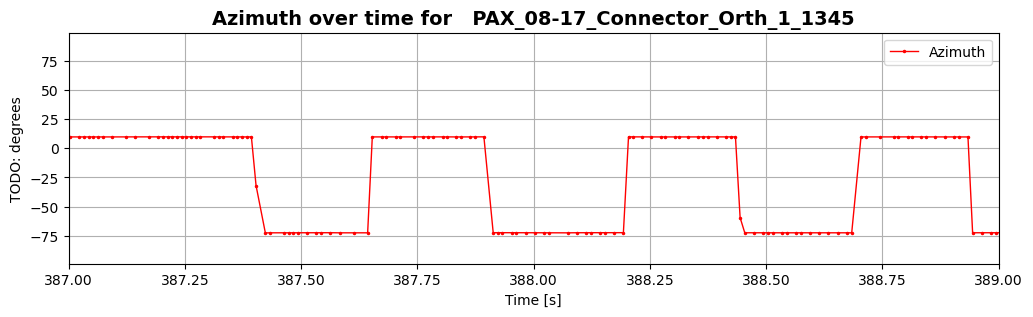

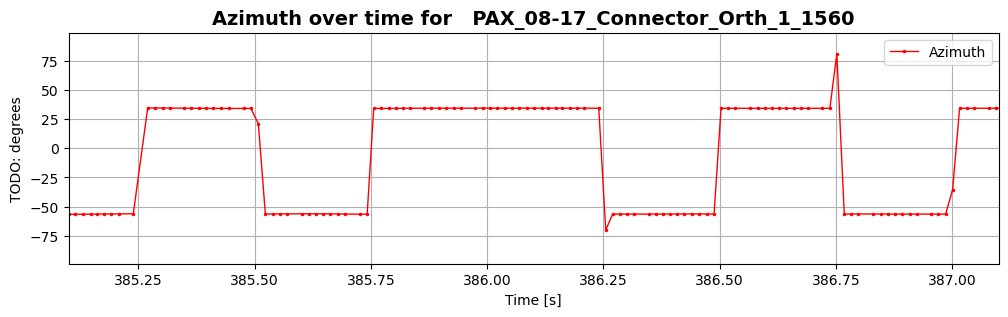

In [111]:
time_offset = 386.2-388.1
p1.plot_raw(sample_range=(387,389),time_offset=time_offset)

In [112]:
p2 = SetPair(filename1,filename2,SwitchSet,set_range=(390,None),time_offset=time_offset)

Time range: min=390.004, max=7512.632
Time range: min=388.109, max=7511.312


In [113]:
filename_1345_input = 'Datasets/Whole_setup/08-17/PAX_08-17_Connector_Orth_1_1345_input.csv'
filename_1560_input = 'Datasets/Whole_setup/08-17/PAX_08-17_Connector_Orth_1_1560_input.csv'
ss_1345_input = StationarySet(filename_1345_input,set_range=(None,5))
ss_1560_input = StationarySet(filename_1560_input,set_range=(None,4))
#ss_1345_input.plot_raw()
#ss_1560_input.plot_raw()
 #,cp_range=(390,490)

Time range: min=0.052, max=4.996
Time range: min=0.024, max=3.993


In [114]:
jv_1345_input = ss_1345_input.average_pol()
jv_1560_input = ss_1560_input.average_pol()
jv_1345_input

((0.5206199310793713+0j), (0.046912553311716794+1.2553155518221488j))

In [104]:
p2.process_switch_sets(ss_1345_input, ss_1560_input, nominal_switch_rate=2, change_point_range_1=(400,500), change_point_range_2=None, n_exclude=3, print_process=False)

ValueError: too many values to unpack (expected 2)

### 08-17 Long dataset

##### Plotting Allan Deviation

In [82]:
sPair = SetPair(filename1, filename2, StationarySet, set_range=(10,386), time_offset=time_offset)

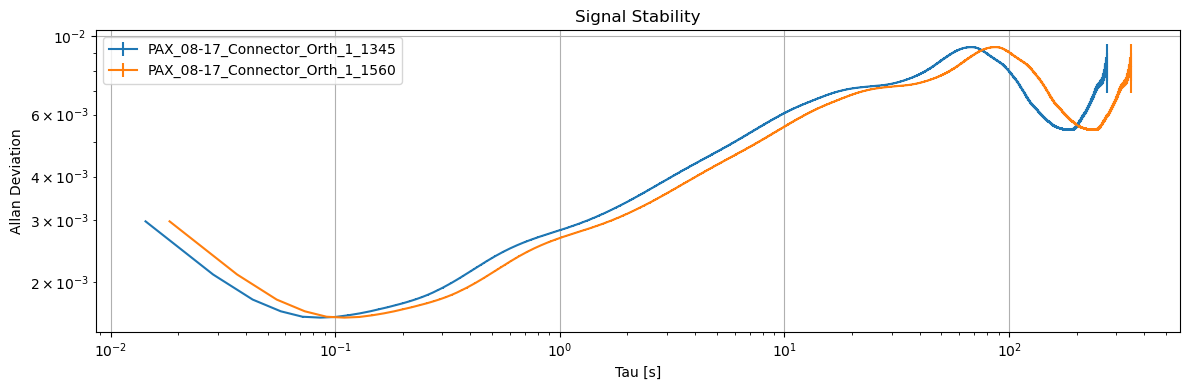

In [84]:
sPair.plot_adev()

##### Synchronizing averaged data

Need to synchronize the averaged data (e.g. want to know which averaged points correspond to each other between the two datasets)
+ First average the signal data for each dataset
    + This will give equally spaced points; two points every nominal_sample_rate seconds
    + If there is missing data (happens occasionally, see '2.2.2 Random') we'll interpolate
+ Input the time offset between the first points taken for each dataset
    + Here is where the SetPair class comes in, as it stores both dataframes and the time offset between them
    + We can plot both datasets on top of each other (maybe not useful)
    + We can plot the polarizations over time for each one? Seems more valuable
+ We should also have the Jones matrices calculated for each pair of signal data points in a single dataset
    + We should be able to compare these matrices (over time) to see if they even correllate in the first place
    + We can apply the inverse operation of signal 1 to signal 2 and see if it's parameters remain steady

In [70]:
plt.ioff()
plt.close('all')

In [71]:
filename = 'Datasets/Whole_setup/08-17/PAX_08-17_Connector_Orth_1_1345.csv'
ds = SwitchSet(filename, set_range=(400,None))

In [72]:
ds.find_switches(nominal_switch_rate=2, change_point_range_1=(400,480), change_point_range_2=(3000,3080), print_process=False)

In [73]:
ds.average_data(print_process=False)

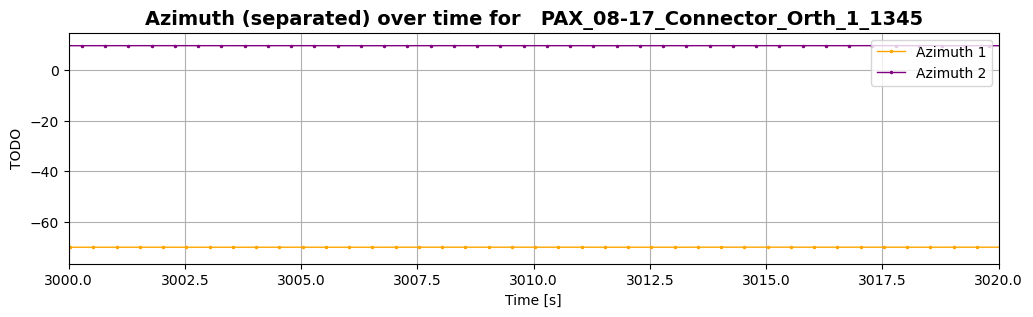

In [74]:
ds.plot_separated(birds_eye=False,sample_range=(3000,3020))

Number of taus used for signal 1: 1886
Number of taus used for signal 2: 1886


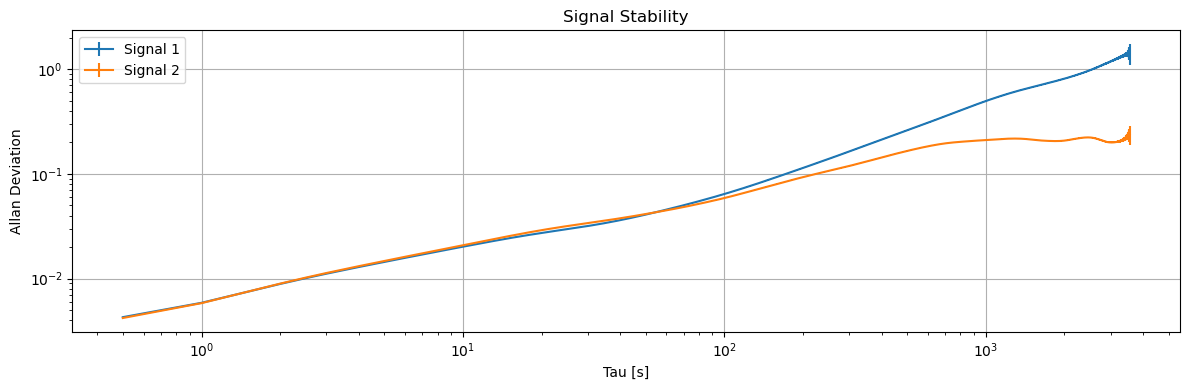

In [75]:
ds.adev(plot_param='Azimuth', plot_adev=True);

##### Debugging

In [281]:
avg_df = ds.avg_df
mid_time = 5067.7
start_time = mid_time - 1.5
end_time = mid_time + 1.5
display(avg_df[(avg_df['EstTime']>start_time) & (avg_df['EstTime']<end_time)])
#display(avg_df.iloc[])

,StartTime,EndTime,AvgTime,EstTime,Length,NumPoints,AvgSampleRate,AzimuthAvg,AzimuthStd,EllipticityAvg,...,S2Std,S3Avg,S3Std,DOPAvg,DOPStd,PowerAvg,PowerStd,TimeDiff,signalMembership,groupNumber
18552,5066.367,5066.497,5066.42575,5066.421296,0.13,8,61.538462,-69.307500,0.008864,-6.121250,...,0.000302,-0.285175,0.000320,100.736250,0.007440,1.335000,0.000000,0.255114,True,20265.0
18553,5066.608,5066.738,5066.683556,5066.671293,0.13,9,69.230769,10.236667,0.005000,2.486667,...,0.000207,0.112211,0.000494,99.668889,0.003333,1.298778,0.000441,0.257806,False,20266.0
0,NaN,NaN,NaN,5066.921290,NaN,-1,NaN,-69.303889,0.008796,-6.134537,...,0.000296,-0.285754,0.000311,100.731944,0.012031,1.334963,0.000111,NaN,True,20267.0
0,NaN,NaN,NaN,5067.171287,NaN,-1,NaN,10.230833,0.005871,2.487917,...,0.000211,0.112268,0.000428,99.669444,0.003799,1.298389,0.000220,NaN,False,20268.0
0,NaN,NaN,NaN,5067.421284,NaN,-1,NaN,-69.300278,0.008728,-6.147824,...,0.000290,-0.286332,0.000302,100.727639,0.016622,1.334926,0.000222,NaN,True,20269.0
18554,5067.589,5067.759,5067.674833,5067.671281,0.17,12,70.588235,10.225000,0.006742,2.489167,...,0.000215,0.112325,0.000362,99.670000,0.004264,1.298000,0.000000,0.991278,False,20270.0
18555,5067.879,5068.009,5067.940111,5067.921278,0.13,9,69.230769,-69.296667,0.008660,-6.161111,...,0.000283,-0.286911,0.000293,100.723333,0.021213,1.334889,0.000333,0.265278,True,20271.0
18556,5068.09,5068.25,5068.177857,5068.171274,0.16,14,87.5,10.225714,0.007559,2.507857,...,0.000295,0.113114,0.000285,99.670714,0.002673,1.298000,0.000000,0.237746,False,20272.0
18557,5068.34,5068.501,5068.413154,5068.421271,0.161,13,80.745342,-69.296154,0.006504,-6.176154,...,0.000199,-0.287646,0.000348,100.736923,0.015484,1.334923,0.000277,0.235297,True,20273.0
18558,5068.621,5068.751,5068.687,5068.671268,0.13,10,76.923077,10.221000,0.007379,2.514000,...,0.000271,0.113450,0.000354,99.672000,0.004216,1.298000,0.000000,0.273846,False,20274.0


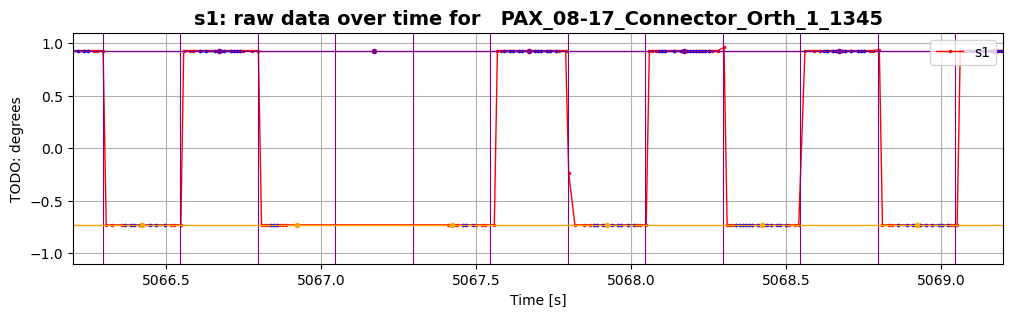

In [282]:
ds.plot_raw(birds_eye=False,sample_range=(start_time,end_time),plot_param='s1',plot_switch=True,plot_valid=True,plot_avg=True)
#rate_hist_fig = ds.rate_hist(bins=80); display(rate_hist_fig); plt.close(rate_hist_fig)

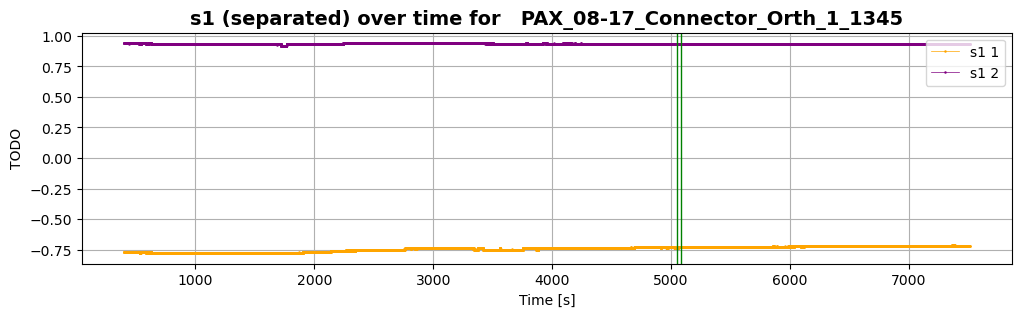

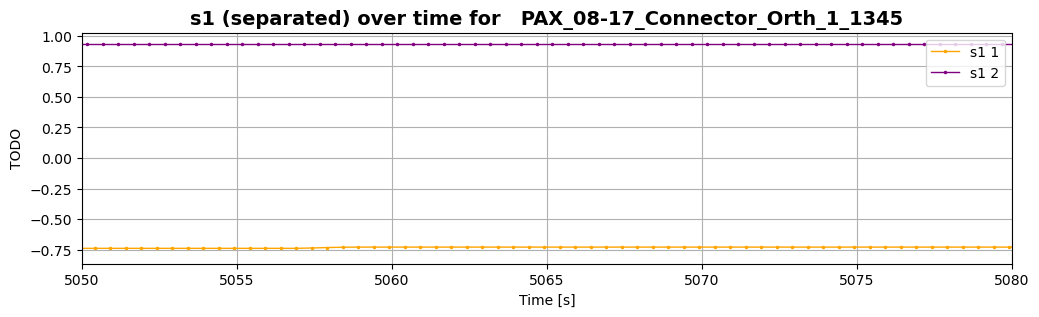

In [287]:
ds.plot_separated(birds_eye=True,sample_range=(5050,5080),plot_param='s1')

In [244]:
data = {'A': [10, 20, 30, 40],
        'B': [15, 25, 35, 45]}
df = pd.DataFrame(data)

#display(df)

ind = 2
prev_row = df.iloc[ind-1]
next_row = df.iloc[ind]
avg_row = (prev_row+next_row)/2

latter_df = df.iloc[ind:]
# display(latter_df)
# display(df)
# latter_df.index = latter_df.index + 1
# display(latter_df)
# display(df)
new_df = pd.concat([df.iloc[:ind],pd.DataFrame([avg_row]),df.iloc[ind:]])
display(new_df)
# display(new_df.iloc[:ind])
# display(new_df.iloc[ind:])
# new_df.reset_index(drop=True,inplace=True)
display(new_df.iloc[ind])
new_ind = new_df.index.get_loc(ind)
display(new_df.iloc[new_ind])
print(ind)
print(new_ind)
display(new_df.iloc[2])
#display(new_df.iloc[:ind])
#display(new_df.iloc[ind:])
#display(new_df.loc[:ind])
#display(new_df.loc[ind:])
#last = new_df.loc[:ind]
#display(last.iloc[:len(last)-1])

,A,B
0,10.0,15.0
1,20.0,25.0
0,25.0,30.0
2,30.0,35.0
3,40.0,45.0


A    25.0
B    30.0
Name: 0, dtype: float64

A    30.0
B    35.0
Name: 2, dtype: float64

2
3


A    25.0
B    30.0
Name: 0, dtype: float64